In [ ]:
# Imports
!pip install cpmpy numpy colorama networkx matplotlib requests z3-solver --quiet

import cpmpy as cp
import numpy as np

(You can ignore google* and tensor* dependency errors on Google Colab.)


## **Session 2: Reification, solving, debugging and explaining**

In this session, we will cover a collection of concepts you would need to master as to efficiently and effectively create Constraint Programming models of your own:


1) Debugging

2) Solving

3) Explaining

4) Reification

We will cover each of them in a separate section; guiding you through an example, followed by a modelling exercise.

**Useful Resources:**
* CPMpy summary sheet: https://cpmpy.readthedocs.io/en/latest/summary.html
* CPMpy modeling documentation: https://cpmpy.readthedocs.io/en/latest/modeling.html

### **Part 1: Debugging**

In this section, we'll look at a quite usefull topic for when designing your own Constraint Programming models: **debugging**.

You've made a model, and now you are trying to solve it. But oh no, you get:
- an error
- no solution
- an incorrect solution

We've gotten ourselves a BUG!



<!-- <div>
    <img src="attachment:e1a4c1fb-dfbc-43a1-a092-3244c1a23c06.png" width="300"/>
</div> -->


<div>
    <img src="https://pngpix.com/images/hd/cartoon-ladybug-illustration-7lugnuh6u9q5fm98.jpg" width="300"/>
</div>


<!-- ![image.png](attachment:e1a4c1fb-dfbc-43a1-a092-3244c1a23c06.png)![image.png](attachment:2b4e9a5b-1293-41a1-b1e2-3d549d0d301e.png) -->

From previous courses you should already have some experience with debugging. But now we are working with a declarative language, so how do you "*debug a model*"? There is no such thing as setting break-points and going through the lines of code step-by-step. The solver is assumed to be a "black box", inaccessible for us modelers.

Luckily, the expert modeler [Håkan Kjellerstrand](http://www.hakank.org/) has some tips for us:
- Test the model **early and often**
- When a model is not working, **activate the constraints one by one** to test which constraint (or combination) is the culprit.
- **Check the domains** of the decision variables

The idea is that by doing the first point often, there is a limited need for the second (which is more tedious).

The bug can be situated in one of three layers:
1. your model
2. the modeling library (CPMpy)
3. the solver

They are ordered from most likely to least likely! The last two are more meant for solver developers and for us, your teaching assistants (Tias' research group is responsible for the development of CPMpy, have a [look](https://github.com/CPMpy/cpmpy) at our work ;) )

We'll only cover the first type. We've seen some common modeling mistakes in the lectures. Let's see if you're able to spot all of them, and of couse provide a correction.

#### **0. Setup**

In [ ]:
from colorama import Fore, Style, init
# A small function to give you feedback whether you've correctly fixed the upcoming "Warehouse Container Problem"
def used_capacity(x):
    a = np.sum(x * np.array([[2,3,5]]).T, axis=0)
    res = f"{'Over capacity: ' if any(a > 10) else 'OK: '}\n"
    for i,b in enumerate(a):
        res += f"{Fore.RED if b > 10 else Fore.GREEN}Container {i}: {b} / {10}\n"
    res += Style.RESET_ALL
    return res

#### **1. Syntax Errors**

The bugs to be found in the models below belong to the category of "**syntax errors**". These are of course the easiest to catch, since the Python interpreter will detect them for you and will raise an error.

##### **1.1. Worker Assignment**

A factory needs to assign 4 workers (W1, W2, W3, W4) to 4 different tasks (T1, T2, T3, T4). Each worker can perform one task at a time, and every task must be completed by exactly one worker.

Additionally:

- W1 can only work on Task 1 or Task 2.
- W2 cannot work on Task 3.
- W3 must work on either Task 3 or Task 4.
- W4 must work on a different task than Worker 2.

The goal is to assign each worker to a task under these constraints.

In [ ]:
"""
TODO: Debug this model.

HINT: Carefully look at the error message you get.
"""

# Decision Variables
# - x[i] represents the task assigned to worker i (indexed from 1)
x = cp.intvar(1, 4, shape=4, name="x")

# Model
m = cp.Model()

# Constraints:
# - W1 can only work on Task 1 or Task 2
m.add([x[0] == 1 | x[0] == 2])
# - W2 cannot work on Task 3
m.add([x[1] != 3])
# - W3 must work on Task 3 or Task 4
m.add([x[2] == 3 | x[2] == 4])
# - W4 must work on a different task than W2
m.add([x[3] != x[1]])
# - All tasks must be assigned to different workers (all different constraint)
m.add([cp.AllDifferent(x)])

# Solve the model
if m.solve():
    print("Solution found:")
    print("Task assignments:", x.value())
else:
    print("No solution found.")

##### **1.2. Machine Configuration**

A manufacturing plant operates several machines that need to be calibrated regularly to ensure they are functioning at peak efficiency. The calibration involves adjusting four key machine settings (a, b, c, and d), each of which has a specific range of values.

The maintenance team has a calibration checklist:
- Setting a can be adjusted between 0 and 4.
- Setting b can be adjusted between 0 and 3.
- Setting c must be set between 1 and 4.
- Setting d must be set between 1 and 3.

Calibration Requirements:
- At most two settings can be set to exactly 3 to avoid overloading the machines with a high configuration in too many settings.
- At least one setting must be exactly 2 to ensure a certain degree of stability across the machine settings.

In [ ]:
"""
TODO: Debug this model.
"""

# Decision Variables
# - Machine settings represented by integer variables
a = cp.intvar(0, 4, name="a")
b = cp.intvar(0, 3, name="b")
c = cp.intvar(1, 4, name="c")
d = cp.intvar(1, 3, name="d")

# - List of settings
e = [a, b, c, d]

# Model
m = cp.Model()

# Constraints
# - At most 2 settings can be exactly 3
m.add(cp.sum(e == 3) <= 2)
# - At least 1 setting must be exactly 2
m.add(cp.sum(e == 2) >= 1)

# Solve the model
if m.solve():
    print("Optimal machine settings found:")
    print("Setting a:", a.value())
    print("Setting b:", b.value())
    print("Setting c:", c.value())
    print("Setting d:", d.value())
else:
    print("No valid configuration found.")

#### **2. Unexpected UNSAT**

Now we'll look at more difficult bugs, the ones where the model does not have errors but still doesn't return a solution (when we were expecting one).

##### **2.1. Organizing the Harmony Festival**

The town of Meadowvale is buzzing with excitement as the annual Harmony Festival approaches. This year, a diverse group of friends and acquaintances has come together to make the festival a success. However, their relationships are complicated; some are good friends, while others have a history of conflict.

**Characters**
- **Sophie** : The enthusiastic organizer who is in charge of the **Food Stall**. She believes good food brings people together.
- **Jake** : A talented musician responsible for arranging **Live Music**. He loves performing but has a rivalry with another group: Emily.
- **Emily** : A passionate community member organizing a **Workshop** on sustainable living. She wants to educate attendees but is not on good terms with Jake due to past disagreements.
- **Oliver** : The festival's logistics manager. He aims to ensure everything runs smoothly but is caught in the middle of the tensions.

**Festival Events and Constraints**
- **Food Stall (A)**: If Sophie sets up a food stall, Jake must provide live music to create a lively atmosphere.
- **Live Music (B)**: Jake is excited to perform, but if he is on stage, Emily cannot conduct her workshop, as their past conflicts would create tension and distract the attendees.
- **Workshop (C)**: If Emily organizes her workshop, she insists that there must be a food stall, as refreshments will be crucial for participants. But she will not turn up of Jake is also there.

**Objective**
The goal is to maximize the number of events while avoiding conflicts.

In [ ]:
"""
TODO: Debug this model.
"""

# Decision Variables
# - define binary variables for events
A = cp.boolvar(name="Food_Stall")  # True if there is a food stall
B = cp.boolvar(name="Live_Music")  # True if there is live music
C = cp.boolvar(name="Workshop")    # True if there is a workshop

# Model
model = cp.Model()

# Constraints
# 1) If there is a food stall, there must be live music
if A:
    model.add(B)
# 2) If there is live music, there cannot be a workshop
if B:
    model.add(~C)
# 3) If there is a workshop, there must be a food stall, there can't be live music
if C:
    model.add(A)
    model.add(~B)

# Objective
model.maximize(A + B + C)

# Solve the model
if model.solve():
    print("Festival Setup:")
    print(f"Food Stall: {'Yes' if A.value() else 'No'}")
    print(f"Live Music: {'Yes' if B.value() else 'No'}")
    print(f"Workshop: {'Yes' if C.value() else 'No'}")
else:
    print("No feasible setup exists for the festival.")


##### **2.2. Threasure Hunt**

A group of treasure hunters is preparing for an expedition and needs to pack a limited-capacity knapsack for the journey. They have four valuable artifacts with different weights and values, and their challenge is to select at least three of them to maximize the total value they can carry without exceeding the knapsack's weight limit.

The hunters have identified four items with the following properties:

- Weights: [2, 3, 4, 5] (in kilograms)
- Values: [3, 4, 5, 6] (in monetary units)

The knapsack can hold a maximum weight of 10 kilograms, and the hunters must select a combination of artifacts that maximizes the total value while staying within the weight limit.

In [ ]:
"""
TODO: Debug this model.

HINT: Keep the tips from Håkan Kjellerstrand in mind.
"""

# Parameters of the Problem
weights = [2, 3, 4, 5]  # weight of each item
values = [3, 4, 5, 6]   # value of each item
capacity = 10           # maximum weight capacity of the knapsack

n_items = len(weights)

# Decision Variables
x = cp.boolvar(shape=n_items) # a binary decision variable for each item (0 = don't take, 1 = take)
total_weight = cp.intvar(0, 10)
total_value = cp.intvar(0, 10)

# Model
model = cp.Model()

# Constraints
model.add( total_weight <= capacity )             # weight constraint
model.add( total_weight == cp.sum(x * weights) )  # total weight
model.add( total_value == cp.sum(x * values) )    # total value
model.add( cp.sum(x) >= 3 )                       # min number of items

# Objective
model.maximize(total_value) # objective to maximize the total value

# Solve the model
if model.solve():
    print("Optimal selection of items:", x.value())
    print("Total weight:", total_weight.value())
    print("Total value:", total_value.value())
else:
    print("No solution found")

#### **3. Unexpected Solution**

Then there is the most difficult catergory of bugs, the ones where there is no error in the model, where the model does return a solution, but where the solution is not what we expected it to be. We've made a mistake when translating the problem description to the model formulation, and these mistakes can be very subtle. Have we forgotten a constraint, maybe an edge-case, does the constraint not express what we intended, etc?

##### **3.1. Warehouse Container Problem**

A warehouse needs to store different types of goods in containers. The warehouse has 4 containers, each with a limited space capacity. There are 3 types of goods (A, B, and C) that need to be stored in these containers. The problem constraints are as follows:

- Each container can hold a maximum of 10 **units of space**.
- Goods of type A require 2 **units of space** for each item.
- Goods of type B require 3 **units of space** for each item.
- Goods of type C require 5 **units of space** for each item.
- The warehouse needs to store exactly 5 items of type A, 4 items of type B, and 3 items of type C.

The objective is to assign the goods to the containers such that the capacity constraints are respected.

In [ ]:
"""
TODO: Debug this model.
"""

# Decision Variables
# - x[i, j] represents how many items of good i are placed in container j
x = cp.intvar(0, 5, shape=(3, 4), name="x")  # 3 types of goods, 4 containers

# Model
model = cp.Model()

# Constraints:
# 1. Each container can hold a maximum of 10 units of volume
for j in range(4):
    model.add([cp.sum(x[:, j]) <= 10])  # Total amount of items in container j
# 2. The warehouse must store exactly 5 items of type A, 4 items of type B, and 3 items of type C
model.add(cp.sum(x[0, :]) == 5)  # 5 items of type A
model.add(cp.sum(x[1, :]) == 4)  # 4 items of type B
model.add(cp.sum(x[2, :]) == 3)  # 3 items of type C

# Solve the model
if model.solve():
    print("Solution found:")
    print(x.value())
    print(used_capacity(x.value()))
else:
    print("No solution found.")

### **Part 2: Solving**

Now that we have a basic understanding of how to model within a high-level modeling language the likes of CPMpy - using concepts such as decision variables, constraints, objective function, etc. - we'll have a deeper look at the second component of the paradigm: model + **SOLVE**.

As seen in the lectures, Constraint Programming (CP) is a declarative paradigm. We model the "**what**" and the solver takes care of the "**how**".
Many different solvers/solving technologies can be used as "backends" for a high-level language. They differ in:
- The constraints they support (including global constraints/functions)
- How they perform search and propagation (CP vs MIP vs PB vs SAT)
- How they guide the search (heuristics, hyper-parameters)
- . . .

High-level modeling languages such as CPMpy allow us to reason on a more conceptual level using generic CP primitives, without having to interact with solver specific APIs. Upon calling `solve` (`model.solve()` in CPMpy), any such modeling language will have to take care of re-encoding the user-provided model into a solver-specific input format through a series of transformations.

<!-- Image will be hidden on google colab -->
<!-- <div>
    <img src="attachment:aa4945ac-4f28-4522-89e2-986b14f5f5a6.png" width="500"/>
</div>
 -->


<!-- ![image.png](attachment:aa4945ac-4f28-4522-89e2-986b14f5f5a6.png) -->


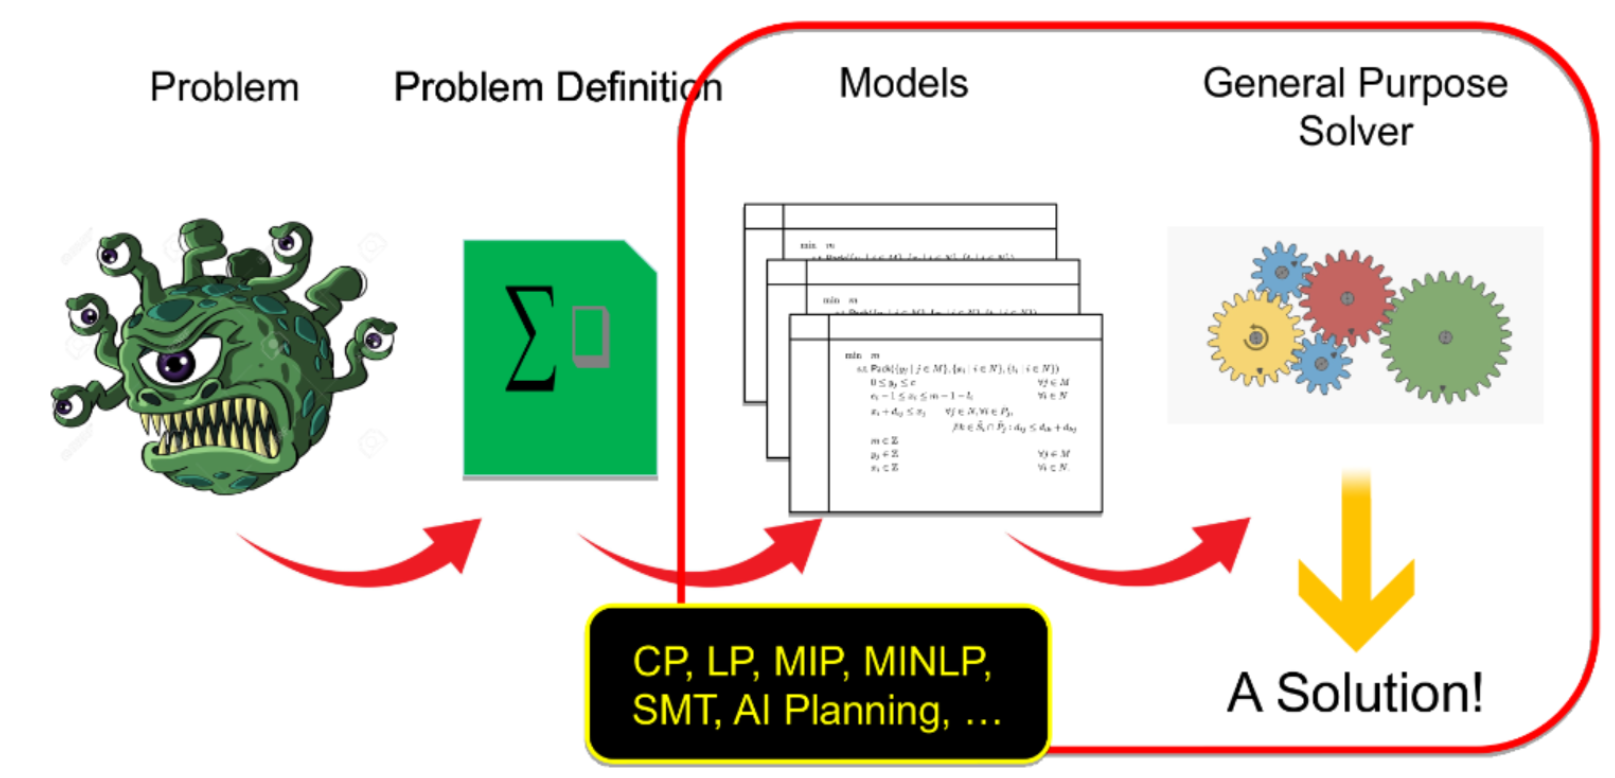

#### **0. Setup**

In [ ]:
# Support code for the 'Team Skill Assignment Problem'

def print_solution():
    sol = team_assign.value()
    strings = []
    for p in range(P):
        assigned_employees = [e for e in range(E) if sol[p, e] == 1]
        strings.append(f"  Project {p}: Employees {assigned_employees}")
    width = max([len(s) for s in strings])+1
    print("┌" + "─"*width + "┐")
    for s in strings:
        print("│" + s + " "*(width-len(s)) + "│")
    print("└" + "─"*width + "┘")

def check_solution(): # Will give you feedback on the solution your model returns
    M, N = team_assign.shape  # M: number of projects, N: number of employees
    _, S = employee_skills.shape  # S: number of skills

    # Check each project
    for p in range(M):

        # Get the employees assigned to project p
        team = [e for e in range(N) if team_assign.value()[p, e] == 1]
        team_size = len(team)

        # Constraint 1: Team size constraint (T_min <= team size <= T_max)
        if not (T_min <= team_size <= T_max):
            print(f"Project {p} team size constraint violated: team size is {team_size}, but should be between {T_min} and {T_max}.")
            return

        # Constraint 2: Skill coverage constraint
        for s in range(S):
            # Check if the team covers the skill requirement of the project
            skill_coverage = sum(employee_skills[e][s] for e in team)
            if project_skills[p][s] == 1 and skill_coverage == 0:
                print(f"Project {p} skill coverage constraint violated: skill {s} is required, but no team member has it.")
                return

        # Constraint 3: No employee assigned to more than one project
        for e in range(N):
            projects_assigned = sum(team_assign.value()[p, e] for p in range(M))
            if projects_assigned > 1:
                print(f"Employee {e} is assigned to multiple projects.")
                return

#### **1. Background**

Let's have a deeper look at a very basic CPMpy model using a `max` and an `AllDifferent ` constraint.

In [ ]:
# Decision Variables
[a,b,c,d] = cp.intvar(0, 3, shape=4, name=["a", "b", "c", "d"])

# Model
model = cp.Model()

# Constraints
model.add( (a + b) == cp.max([c, d]) )
model.add(cp.AllDifferent([a,b,c,d]))

# Solve
model.solve()

# Print solution
print(a.value(), b.value(), c.value(), d.value())

Simple enough.

Calling `m.solve()` will transform the model to a solver specific input format (a language that the solver understands), pass the model onto the solver (called "posting"), and get the result back (made available through the `.value()` method of the respective decision variables). The default solver of CPMpy is Google's OR-Tools. But thanks to the high-level nature of our modeling language, we can choose a different solver ("backend") without having to change anything about our model. The model is solver independant, a true "Model + Solve" paradigm.

We can demonstrate this by solving the model again using a different solver, e.g. Z3 from Microsoft.

In [ ]:
"""
TODO: Solve the model again using the 'z3' solver.

HINT: Use "model.solve?" to get the documentation on how to change the solver.
      (using ? is a feature of jupyter notebooks,
      it returns the documentation of whatever is in front)
      Check if the solution is still the same.
"""
# model.solve(...)


# Print solution
print(a.value(), b.value(), c.value(), d.value())

Because the problem does not have a unique solution, you might now have gotten a different one.

The interface of 'Z3' (an SMT solver) is completely different from that of 'OR-Tools' (a CP solver). How do high-level modeling languages like CPMpy handle this? Through equivalence preserving transformations!

Let's have a quick look. (We'll tackle the differences between solver technologies in more detail in a later session)

We can first look at the high-level CPMpy model which has been created:

In [ ]:
print(model)

Exactly what we specified. Now let's look at the complete transformation for the default solver (Google's OR-Tools):

In [ ]:
# No need to be able to use this code, just roughly understand what it does
s = cp.SolverLookup().get("ortools") # different way of choosing a solver backend
transformed = s.transform(model.constraints) # let constraint go through the transformation pipeline
for constraint in transformed:
    print(constraint)

Hmm, the `max` constraint has been re-written, extracting the `sum` sub-expression out of it.

Let's look at 'Z3'.

In [ ]:
# No need to be able to use this code, just roughly understand what it does
s = cp.SolverLookup().get("z3") # different way of choosing a solver backend
transformed = s.transform(model.constraints) # let constraint go through the transformation pipeline
for constraint in transformed:
    print(constraint)

An even different transformation, required by the also different API of the 'Z3' solver. It seems like the `max` constraint was not supported by the solver and CPMpy needed to re-write it using simpler constraints.

Thanks to high-level modeling languages, we don't have to deal with the specifics of these solvers and can simply write a generic CP model that can be used across many.

<!-- ![image.png](attachment:d9913ec1-cff3-4c26-be7c-fefbee97ffb7.png) -->

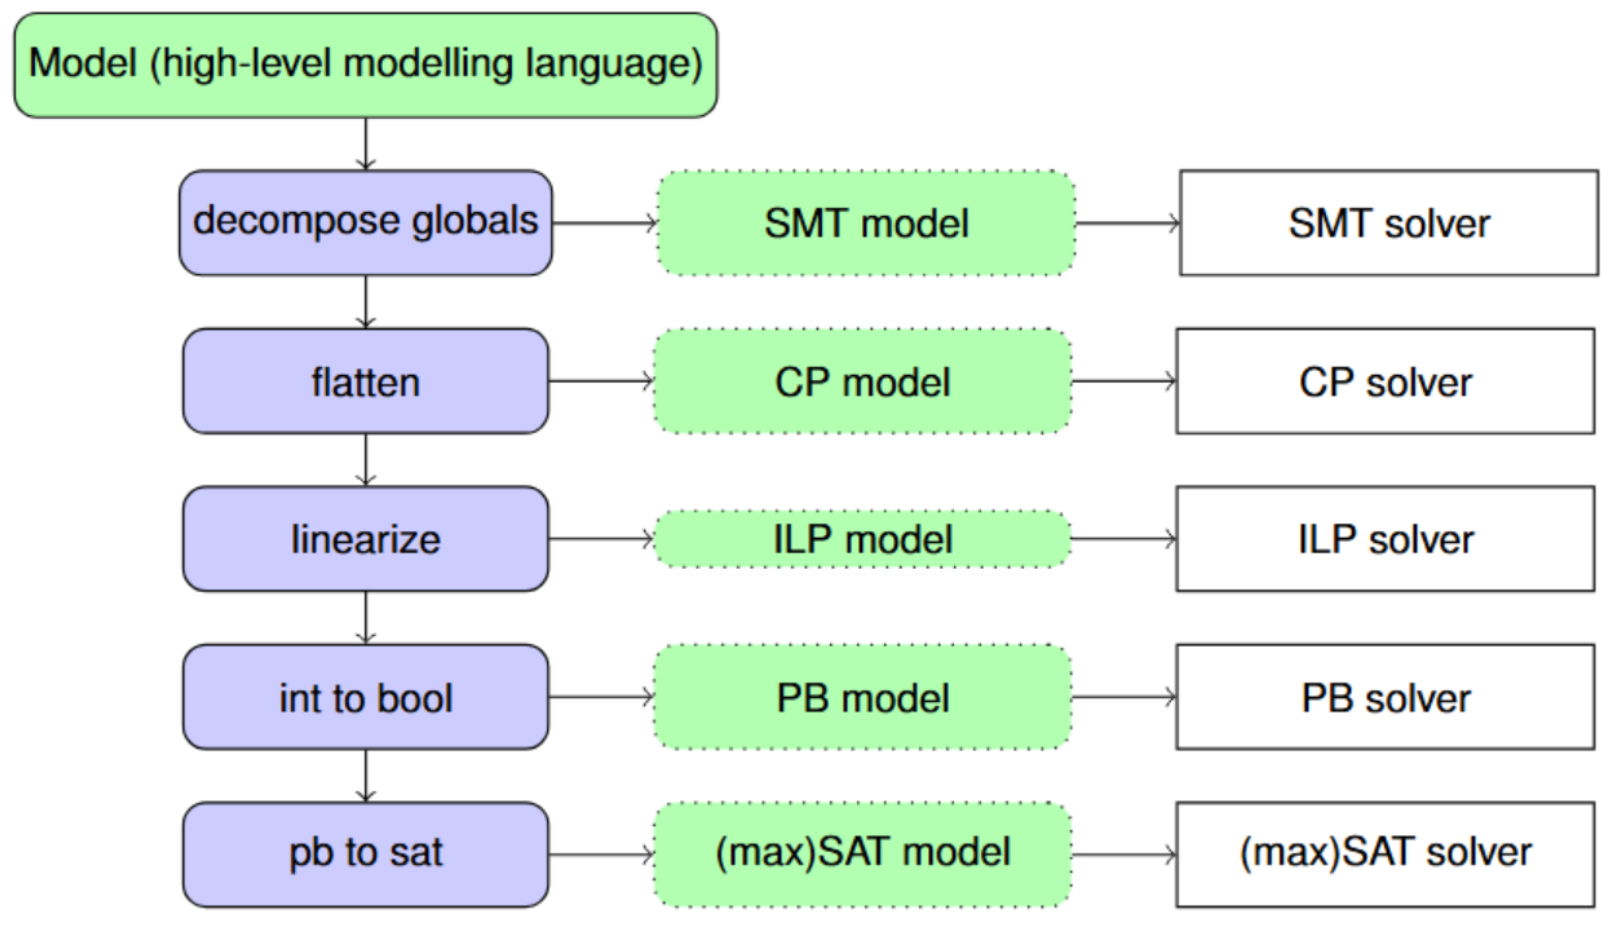

<div style="background-color: #e7f3fe; border-left: 6px solid #2196F3; padding: 10px; margin: 10px 0;">
    <strong>Note:</strong> Whilst high-level modeling languages allow us to write models that will transparently function across different solvers built with different technologies, this does not mean that we can ignore it completely. Taking a bit into account what a chosen solver is good at, which type of formulations it prefers, can definitely lead to performance benefits.
</div>

#### **2. Multiple Solutions**

We know how to get a solution from a CP model using a (specific) solver. But there are many situations in which we are interested in more than one solution.

How do we get all of them? In the documentation of CPMpy, there is a section on [obtaining multiple solutions](https://cpmpy.readthedocs.io/en/latest/multiple_solutions.html), which has also been covered in the lectures.


One technique we've seen is a **model-level** approach: "**Solution enumeration with blocking clauses**". We saw the following pseudo-code:

<!-- ![image.png](attachment:2b27afc4-7b6a-457c-b204-1ead5138e800.png) -->



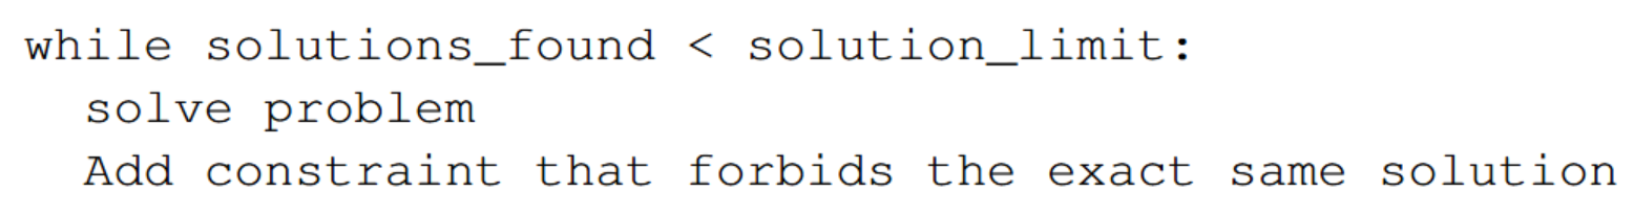

So if we want the next solution to be unique, we should add this restriction to the model in between the solving iterations.

Since needing multiple solutions is often required, many solvers support it more natively in their API. Using this **solver-level** feature instead of **model-level** "blocking clauses" should (if the solver supports it) result in a performance improvement (e.g. the solver does not have to be restarted each time and can just continue where it last left off).

Again CPMpy provides a more high-level and solver independant interface through calling `model.solveAll()`.

Let's look at the example of a **Coin Problem**.

In [ ]:
# Parameters of the Problem
value = 75
coins = [1, 5, 10, 20, 50]

# Decision Variables
counts = cp.intvar(0, 100, shape=5)

# Model
model = cp.Model()

# Constraints
model.add(value == cp.sum(coins*counts))

# Solve
model.solve()

# Print Solution
print(counts.value())

But this is only one of the many possible ways in which the coins can be combined to get to the target value. Using `.solveAll()` we can enumerate them all.

In [ ]:
model.solveAll() # returns the number of solutions found

We can pass a `solution_limit` as to limit the number of solutions to search for. To get the individual solutions, the `display` argument should be used.

In [ ]:
model.solveAll(solution_limit=10, display=[counts])

Implement the **model-level** "blocking clauses" approach and compare the solving speed against a single `.solveAll()` call. Search for 50 solutions.

<div style="background-color: #e7f3fe; border-left: 6px solid #2196F3; padding: 10px; margin: 10px 0;">
    <strong>Note:</strong> Watch out with how you express that solutions must be different. It's easy to make a mistake here, especially when you try to directly translate from natural language. We want to express that the model should no longer return the current solution.
     We want to make the specific combination of <b>all</b> the decision variables of the current assignment no longer valid, not each of the variable assignments on their own. E.g. "(a,b) != (1,4)" is equivalent to "(a != 1) and (b != 4)", which is not the same as "(a != 1) or (b != 4)". Reason carefully about which one you want. Which one of the two is enough to already enforce a different solution, and which one will remove too much from the search space? Maybe print the created expression first as to check if it models what you intended.
</div>

In [ ]:
import time

# Parameters of the Problem
value = 75
coins = [1, 5, 10, 20, 50]

# Decision Variables
counts = cp.intvar(0, 100, shape=5)

# Model
model = cp.Model()

# Constraints
model.add(value == cp.sum(coins*counts))

# 1) Solver-level
start = time.time()
model.solveAll(solution_limit=50)
end = time.time()
print(f"Solver-level took {end-start} seconds")

# 2) Model-level
start = time.time()
for _ in range(50):
    model.solve()

    """
    TODO: Implement the technique of "Solution enumeration with blocking clauses"
          i.e. solve for a solution and remove it from the solution domain for the next iteration.
    """




end = time.time()
print(f"Model-level took {end-start} seconds")


You should notice a significant performance difference when the solver natively supports enumerating multiple solutions through `.solveAll()`.

<div style="background-color: #e7f3fe; border-left: 6px solid #2196F3; padding: 10px; margin: 10px 0;">
    <strong>Note:</strong> For solvers that do not support it natively, CPMpy will itself also fall back to "Solution enumeration with blocking clauses" in the implementation of solveAll.
</div>

We are able to print the solutions, but that is not enough if we want to execute some post-processing code on them. For that it would be nice if we were able to collect them in a list. This is were a callback function comes into place. Just pass a function, taking zero arguments, to the 'display' argument and that function will be called in between each solve iteration.

In [ ]:
# Parameters of the Problem
value = 75
coins = [1, 5, 10, 20, 50]

# Decision Variables
counts = cp.intvar(0, 100, shape=5)

# Model
model = cp.Model()

# Constraints
model.add(value == cp.sum(coins*counts))

solutions = []

"""
TODO: Create a function 'collect' that will append the current '.value()' of the
      decision variables to the 'solutions' list.
      Solve the model again using 'collect' as a callback function.
"""

def collect():
   pass


model.solveAll(solver="ortools", display=collect)

print(f"The 'solution' list has length {len(solutions)}")

You should get the same number of solutions.

#### **3. Team Skill Assignment Problem**

You are tasked with assigning employees to teams for a set of projects. Each project requires a specific set of skills, and teams must be formed such that all required skills are covered. The company has the following constraints:

- There are E employees, P projects and S unique skills.
- Employees can only be assigned to at most one project.
- Each employee has one or more skills, and each project has specific skill requirements.
- A team for each project must consist of at least `T_min` and at most `T_max` employees.

The project manager highlights that flexibility is needed. Employees might need to be rotated between projects to account for future changes in availability or unforeseen challenges. Therefore, the boss requests multiple valid team configurations to be prepared in advance.

You must generate several alternative team assignments where:
- All constraints (skill coverage, team size) are met.
- Each solution provides a different valid team composition.

In [ ]:
# Parameters of the Problem
E = 10  # number of employees
P = 3   # number of projects
S = 5   # number of skills
num_solutions = 3 # amount of unique solutions to solve for

np.random.seed(0)  # for reproducibility

# Skill matrix: employee_skills[e][s] is 1 if employee e has skill s, else 0
employee_skills = np.random.randint(0, 2, (E, S))

# Project skill requirements: project_skills[p][s] is 1 if project p requires skill s, else 0
project_skills = np.random.randint(0, 2, (P, S))

# Team size constraints
T_min = 2  # minimum number of employees in a team
T_max = 5  # maximum number of employees in a team

# ----------

# Decision Variables
# - team_assign[p, e]: 1 if employee e is assigned to project p, else 0
team_assign = cp.boolvar(shape=(P, E), name="team_assign")

# Model
model = cp.Model()

# Constraints - TODO
"""
TODO: Add the missing constraints to the model.
"""
for p in range(P):
    # 1) Each team should have between T_min and T_max employees
    # HINT: To get all employee assignments on a single project p,
    #       you can use numpy's index slicing: team_assign[p,:]
    # ...




    for s in range(S):
        # 2) Skill requirement for each project
        if project_skills[p, s]: # if project p requires skill s
            # HINT: Calculate for project p how much of skill s it has available.
            #       (how many of the employees that have skill s, have been assigned to project p)?
            #       Make a sum over the employees boolean assignment variables (team_assign)
            #       (for those that have the skill s).
            #       The project should have at least 1 employee for each required skill s.
            # ...




# 3) Employees can only be assigned to at most one project
# HINT: To sum over only one dimension of a multi-dimensional array,
#       look at numpy's sum with its axis argument:
#       (https://numpy.org/doc/stable/reference/generated/numpy.sum.html)
# ...






solutions = []

"""
TODO: Add some code to find multiple unique solutions.
      Experiment with both 'blocking clauses' and with CPMpy's built-in '.solveAll()' function
      to get multiple solutions.
"""

# Use this function as callback for the .solveAll() call
def my_function():
    print_solution()
    check_solution()

`check_solution()` will ... check the solution for you. If you don't get any remarks from it (which get printed in between you solutions) then your implementation will most likely be correct.

### **Part 3: Explaining**

In this section, we'll cover the topic of "*eXplainable Constraint Programming*" (XCP). The motivation is as follows:

You're working on a CP model for a problem you want solved. Using all the knowledge you've already gained from this course, and after a lot of debugging, the model has been completed. Time to solve it! But what now? No errors, but still not the answer you expected.

It could be:
- UNSAT
- a strange solution
- a not good enough solution

How do we fix this? The model has no syntactical errors, but maybe it has modeling errors (does not encode the problem you actually intended). Or maybe you would just like to better understand why you got a certain (non-) solution or why the current one is the most optimal (why not better?). This is where **explainable AI** comes into play, since the solver acts as a black box.

As seen in the lectures, there are 2 patterns of explanations:
- **Deductive**: How was X derived? (Why I didn’t get any solution?)
- **Counterfactual** Why X and not Z ? (How can I make it satisfiable?)

To better understand these types of explanations, and how they can be "derived" from our model specification, we'll quickly go through the same example as seen in the lecture: the **Graph Coloring Problem**.

#### **0. Setup**

In [ ]:
# Support code fo the 'Graph Coloring Problem'
from typing import List
import matplotlib.pyplot as plt
import networkx as nx
import re
from cpmpy.expressions.utils import flatlist

draw = lambda g, **kwargs: (nx.draw_circular(g, width=5, node_size=500, **kwargs), plt.show())
cmap = plt.get_cmap('tab10').colors #["black", "yellow", "cyan", "lightgreen", "blue"]

def get_colors(color:List[int]):
    return [cmap[c] for c in color]

def show_graph(nodes, edges, color=[], conflicts=[], satisfiable=[], corrections=[], **kwargs):
    graph = nx.Graph()
    graph.add_nodes_from(nodes)
    graph.add_edges_from(edges)

    conflicts = flatlist(conflicts)
    satisfiable = flatlist(satisfiable)
    corrections = flatlist(corrections)

    conflict_edges = []
    for c in conflicts:
        n1, n2 = c.args
        if n1.name == "max": continue
        a = int(re.search(r"\[[0-9]*\]", str(n1)).group()[1:-1])
        b = int(re.search(r"\[[0-9]*\]", str(n2)).group()[1:-1])
        conflict_edges.append((a, b))

    sat_edges = []
    for c in satisfiable:
        n1, n2 = c.args
        if n1.name == "max": continue
        a = int(re.search(r"\[[0-9]*\]", str(n1)).group()[1:-1])
        b = int(re.search(r"\[[0-9]*\]", str(n2)).group()[1:-1])
        sat_edges.append((a, b))

    correction_edges = []
    for c in corrections:
        n1, n2 = c.args
        if n1.name == "max": continue
        a = int(re.search(r"\[[0-9]*\]", str(n1)).group()[1:-1])
        b = int(re.search(r"\[[0-9]*\]", str(n2)).group()[1:-1])
        correction_edges.append((a, b))

    colors = ["red" if (a, b) in conflict_edges else ("green" if (a,b) in sat_edges else ("orange" if (a,b) in correction_edges else "black")) for (a, b) in graph.edges()]
    if len(color) != 0:
        kwargs |= {"node_color": get_colors(color)}
    draw(graph, edge_color=colors, **kwargs)


#### **1. Graph Coloring Problem**

We've already seen the **Graph Coloring Problem** in the lectures. The problem description is as follows:

  "*Given a graph, consisting of nodes and interconnecting edges, assign to each of the nodes a color such that no two adjacent nodes (with an edge in between) have the same color.*"
    
A trivial solution is of course to give each node its own unique color so we never have "clashing" neighbors. To exclude this trivial setting, the problem often also specifies a maximum number of colors that might be used (lower than the number of nodes) and might additionally challenge you to find a solution with the least number of colors.

Let's look at an example graph:

In [ ]:
# A collection of nodes
nodes = [0, 1, 2, 3, 4, 5]
# The edges interconnecting the nodes
# edges = [(0, 2), (0, 4), (0, 5), (1, 2), (1, 3),  (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]
edges = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2,3), (3, 4), (3, 5), (4, 5)]

show_graph(nodes, edges)

And a CPMpy model for the problem:

In [ ]:
def graph_coloring_model(nodes, edges, max_nr_colors:int):

    # Decision Variables
    #   color[i] = j -> node i has color j
    color = cp.intvar(0, max_nr_colors, shape=len(nodes), name="color")

    # Model
    model = cp.Model()

    # Constraints
    # 1) Neighbours cannot have the same color
    model.add([color[n1] != color[n2] for (n1, n2) in edges])
    # 2) Maximally 'max_nr_colors' colors
    model.add(cp.max(color) < max_nr_colors)

    # Objective
    #   minimize the number of used colors
    model.minimize(cp.max(color))

    return model, color

Let's solve the coloring problem on this graph and look at the solution:

In [ ]:
# Create Model
model, color = graph_coloring_model(nodes, edges, len(nodes))

# Solve
model.solve()

# Print Solution
print(f"Node colors: {color.value()}")

# Visualize Solution
show_graph(nodes, edges, color=color.value())

From looking at the solution, we can deduce that our graph requires at least 4 colors and that any less than that will not be possible (since we already modeled it as a minimization objective). If we enforce it, it should become UNSAT. To understand why, we can start using the explanation techniques / tools as seen in the lectures.

In [ ]:
# Create Model
model, color = graph_coloring_model(nodes, edges, 2) # try coloring using only 2 colors

# Solve
print(model.solve())

The first approach is to generate a **MUS** (Minimal Unsatisfiable Subset).

A MUS is a subset of the constraints that is UNSAT, with the additional characteristic that any further subset of that MUS will become SAT; it is minimal. It explains to us **one of possibly many** points of conflict.

In [ ]:
from cpmpy.tools.explain.mus import mus_naive as mus

model, color = graph_coloring_model(nodes, edges, 2) # enforce the use of 2 colors

# Call the 'mus' tool
MUS = mus(model.constraints)

# Print the constraints inside the MUS
print("MUS:")
for constraint in MUS:
    print("  ", constraint)

# Visualize the MUS
show_graph(nodes, edges, conflicts=MUS)

Now we have an explanation for the UNSAT; our graph consists of a 4-clique and such a clique needs at least 4 colors. We've been able to pinpoint **a** possible cause of conflict and explain it in a minimal and understandable way.

But this explanation is not the smallest that we can find. In the lecture we saw that many MUSes may exist, many ways of explaining the same unsatisfiability through different "points of conflict". Imagine we have a preference as to how we would like our explanation. How can we influence which MUS gets shown?

This is a task for an **Optimal Unsatisfiable Subset** (OUS). It expects a set of weights for the different constraints and then finds a MUS which is optimal in regard to the sum of the weights of the included constraints. Providing equal or no weights, will result in finding the smallest MUS.

In [ ]:
from cpmpy.tools.explain.mus import optimal_mus

model, color = graph_coloring_model(nodes, edges, 2) # enforce the use of 2 colors

# Call the 'optimal_mus' tool
OUS = optimal_mus(model.constraints) # don't provide any weights = assume all constraints have equal weights

# Print the constraints inside the OUS
print("OUS:")
for constraint in OUS:
    print("  ", constraint)

# Visualize the OUS
show_graph(nodes, edges, conflicts=OUS)

We can thus already explain the UNSAT with a smaller MUS; a 3-clique.

Next we can make explanations using a **Maximal Satisfiable Subset** (MSS). It has a definition a bit of the opposite of a MUS. Now we have a subset of constraints which is SAT, but if we add any more constraints (of the original problem), the model becomes UNSAT; the subset is maximal. This explains to us which smaller sub-problem would be SAT.

In [ ]:
from cpmpy.tools.explain.mss import mss

model, color = graph_coloring_model(nodes, edges, 2) # enforce the use of 2 colors

# Call the 'mss' tool
MSS = mss(model.constraints, hard=[cp.max(color) < 2]) # added as hard constraint to make sure it is included in the MSS

# Print the constraints inside the MSS
print("MSS:")
for constraint in MSS:
    print("  ", constraint)

# Visualize the MSS
show_graph(nodes, edges, satisfiable=MSS)

So if we kept only these edges, the problem would become SAT. The complement of a MSS is a **Minimal Correction Subset** (MCS), which we can use to explain what needs to be removed (corrected) to make the problem SAT.

In [ ]:
from cpmpy.tools.explain.mcs import mcs

model, color = graph_coloring_model(nodes, edges, 2) # enforce the use of 2 colors

# Call the 'mcs' tool
MCS = mcs(model.constraints, hard=[cp.max(color) < 2]) # added as hard constraint to make sure it is NOT included in the MCS

# Print the constraints inside the MCS
print("MCS:")
for constraint in MCS:
    print("  ", constraint)

# Visualize the MCS
show_graph(nodes, edges, corrections=MCS)

So removing all the edges that create cliques of side 2 or greater.

#### **2. Alignment Photo Problem**

Now it is your turn.

You are tasked with organizing students into a single line for a class photo. Some of the students have specific friends they insist on standing next to. These requests get specified as a collection of wishes *(who, whom)* indicating "*who*" wants to stand next to "*whom*". You need to arrange the students while respecting these friendship constraints.

##### **Setup**

In [ ]:
# Support code

import networkx as nx
import matplotlib.pyplot as plt
import requests
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import networkx as nx
from io import BytesIO
from cpmpy.expressions.utils import flatlist

# Function to download emoji image from the web
def download_emoji(emoji_code):
    response = requests.get(f"https://github.com/twitter/twemoji/raw/master/assets/72x72/{emoji_code}.png")
    return Image.open(BytesIO(response.content)).convert('RGBA')  # Convert to RGBA for transparency support

# Function to convert emoji to unicode code for image link (e.g., 😃 -> 1f603)
def emoji_to_unicode(emoji):
    return '-'.join(f"{ord(c):x}" for c in emoji)

# Function to show a nice graph of the students and their wishes
def show_graph(people, wishes, pos=None, conflict=[], correction=[], satisfiable=[]):
    # Check solution legality
    if pos is not None:
        if len(set(pos)) < len(pos):
            raise ValueError('Two students are standing at the same location, this is not allowed!')

    # Create networkX graph
    G = nx.Graph()
    G.add_nodes_from(list(range(len(people))))
    G.add_edges_from([(who, whom) for (who,whom) in wishes])
    nx_pos = nx.circular_layout(G)

    # Create figure
    fig, ax = plt.subplots()
    nx.draw(G, nx_pos, with_labels=False, node_size=2000, node_color="white", font_size=20, font_color="black", ax=ax)
    nx.draw_networkx_labels(G, nx_pos)

    conflict = flatlist(conflict)
    correction = flatlist(correction)
    satisfiable = flatlist(satisfiable)

    conflict_edges = []
    for c in conflict:
        if c.name == "alldifferent": continue
        n1, n2 = c.args
        if n1.name == "max": continue
        if n1.name == "abs": n1, n2 = n1.args[0].args
        a = int(re.search(r"\[[0-9]*\]", str(n1)).group()[1:-1])
        b = int(re.search(r"\[[0-9]*\]", str(n2)).group()[1:-1])
        conflict_edges.append((min(a, b), max(a, b)))

    sat_edges = []
    for c in satisfiable:
        if c.name == "alldifferent": continue
        n1, n2 = c.args
        if n1.name == "max": continue
        if n1.name == "abs": n1, n2 = n1.args[0].args
        a = int(re.search(r"\[[0-9]*\]", str(n1)).group()[1:-1])
        b = int(re.search(r"\[[0-9]*\]", str(n2)).group()[1:-1])
        sat_edges.append((min(a, b), max(a, b)))

    correction_edges = []
    for c in correction:
        if c.name == "alldifferent": continue
        n1, n2 = c.args
        if n1.name == "max": continue
        if n1.name == "abs": n1, n2 = n1.args[0].args
        a = int(re.search(r"\[[0-9]*\]", str(n1)).group()[1:-1])
        b = int(re.search(r"\[[0-9]*\]", str(n2)).group()[1:-1])
        correction_edges.append((min(a, b), max(a, b)))

    colors = ["red" if (a, b) in conflict_edges else ("green" if (a,b) in sat_edges else ("orange" if (a,b) in correction_edges else "black")) for (a, b) in G.edges()]

    # Color edges
    nx.draw_networkx_edges(G, nx_pos, edgelist=G.edges(), edge_color=colors, width=2, ax=ax)
    if pos is not None: # if a solution position is provided
        green_edges = [wish for wish in wishes if abs(pos[wish[0]] - pos[wish[1]]) == 1]
        nx.draw_networkx_edges(G, nx_pos, edgelist=G.edges(), edge_color='red', width=2, ax=ax)
        nx.draw_networkx_edges(G, nx_pos, edgelist=green_edges, edge_color='green', width=2, ax=ax)

    # Loop through nodes and place emoji images on them
    for node, (x, y) in nx_pos.items():
        emoji_unicode = emoji_to_unicode(people[node])
        emoji_img = download_emoji(emoji_unicode)
        imagebox = OffsetImage(emoji_img, zoom=0.5)
        ab = AnnotationBbox(imagebox, (x, y), frameon=False)
        ax.add_artist(ab)

    plt.tight_layout()
    plt.show()

##### **Problem**

In [ ]:
# Parameters of the problem
students = ["😀", "😇", "😎", "🤠", "🤩", "🧐", "🤕"]
wishes = [(1, 4), (4, 0), (2, 1), (3, 0)] # pairs of indexes into the list of students

def photo_alignment(students, wishes):
    N = len(students)

    # Decision variables
    pos = cp.intvar(0, N-1, shape=N, name="pos")

    # Model
    model = cp.Model()

    # Constraints
    """
    TODO: Fill in the constraints according to the problem description whilst enforcing all student wishes.

    HINT: Students who stand next to each other will have a distance of 1 between them (their 'pos').
          Use cp.abs(...) to get the absolute value of an expression.

    HINT: Don't forget that only one student can stand at the same location.
    """





    # Solve
    sat = model.solve()

    # Show solution
    if sat:
        print("Found a solution:")
        print(f"Student positions: {pos.value()}")
    else:
        print("Problem is UNSAT")

    return model, pos

model, pos = photo_alignment(students, wishes)

If the above result looks right, we can now visualize the problem as a graph and highlight our compliance with the student wishes:

In [ ]:
show_graph(students, wishes, pos=pos)

All edges should be green, indicating that all our student wishes are satisfied.



Let's try again with a different set of wishes

In [ ]:
# Parameters of the problem
students = ["😀", "😇", "😎", "🤠", "🤩", "🧐", "🤕"]
wishes = [(1, 4), (4, 0), (5, 4), (5, 2), (2, 1), (6, 4), (3, 0), (4, 2), (6, 3), (0, 5)] # pairs of indexes into the list of students

model, pos = photo_alignment(students, wishes)

It should be UNSAT.

Use CPMpy's set of tools to explain a point of conflict in this problem. Interpret what this explanation means.

In [ ]:
model, pos = photo_alignment(students, wishes)

"""
TODO: Use the applicable CPMpy tool to compute a point of conflict in our problem.
"""

conflict = None # update with result of an explanation tool


# Print conflict
print("Conflict:")
for constraint in conflict:
    print("  ", constraint)

# Visualize conflict
show_graph(students, wishes, conflict=conflict)

Now explain what compromises to the "wishes" need to be made in order to make the problem SAT?

In [ ]:
model, pos = photo_alignment(students, wishes)

"""
TODO: Use the applicable CPMpy tool to compute which correction needs to be made.
      (there may be multiple alternative options)

HINT: We only want to make corrections to the wishes, so make sure only these constraints can be part of the correction.
      You can pass to the tool a list of constraint which should not be corrected via the 'hard' argument.
"""

correction = None # update with result of an explanation tool


# Print correction
print("Correction:")
for constraint in correction:
    print("  ", constraint)

# Visualize correction
show_graph(students, wishes, correction=correction)

To check your solution, the removal of 4 wishes should be sufficient.

This type of explanation is called a **Counterfactual explanation**:

    How to change the model, in order to find a solution?
    - Find constraints that, if removed, a solution can be found!
    - Find a correction subset . . .

Another type of explanation is that of "**Explaining logical consequences**". See the lecture for more information.



### **Part 4: Reification**

In this section, we'll delve deeper into the concept of **reification** within the Constraint Programming (CP) paradigm. In the lecture slides, reification was introduced as something that "*enables the reasoning about the truth of a constraint or a Boolean expression*".

If we have an expression like $(x < y)$, we could directly add it to a model thus enforce it to be $True$ (an inequality constraint over the decision variables `x` and `y`). On the other hand, we can also introduce a new boolean decision variable `b` and use it to instead reify the constraint. The reification is $b \leftrightarrow (x < y)$, which in CPMpy gets written as `b == (x < y)`.

`b` is known as the reified variable. `b` now allows us to reason about the original expression (without necessarily enforcing it).

As seen in the course, reification is a powerfull mechanism that enables:
- higher-level modelling
- efficient reuse of logical components through their reified variable

It allows for modeling techniques such as **"soft constraints"** (where constraints are not enforced, but a penalty is added for their violations) and **"conditional constraints"** (constraints that are only enforced when a certain condition is met, i.e. if another expression evaluates to $True$).


#### **1. Alignment Photo Problem**

In this exercise, we'll see how to use reification as a means to post expressions as **soft constraints**.

We'll revisit the "Alignment Photo Problem" from the explanation section. Copy-and-paste your previous implementation below.

In [ ]:
def photo_alignment(students, wishes):
    N = len(students)

    # Decision variables
    pos = cp.intvar(0, N-1, shape=N)

    # Model
    model = cp.Model()

    # Constraints
    """
    TODO: Copy-and-paste your previous implementation here.
    """





    # Solve
    sat = model.solve()

    # Show solution
    if sat:
        print("Found a solution:")
        print(f"Student positions: {pos.value()}")
    else:
        print("Problem is UNSAT")

    return model, pos

If we run the problem again on the second set of wishes, we will again get UNSAT.

In [ ]:
# Parameters of the problem
students = ["😀", "😇", "😎", "🤠", "🤩", "🧐", "🤕"]
wishes = [(1, 4), (4, 0), (5, 4), (5, 2), (2, 1), (6, 4), (3, 0), (4, 2), (6, 3), (0, 5)] # pairs of indexes into the list of students

model, pos = photo_alignment(students, wishes)

In the previous section we explained what needed to be corrected (i.e. which wishes would need to be dropped) to make the problem SAT. The result was an MCS; a minimal set of constraints which can be removed from the original problem in order to make it SAT. So now we can manually remove those constraints and the model should become solvable.

An alternative approach would be to use reification. From the MCS we gotten the insight that we have too many "wishes", resulting in conflicts. Modeling these wishes as "**soft**" instead of "**hard**" constraints and maximizing the number of satisfied wishes, will give a similar result without having to manually start removing constraints.


Re-implement the model, but now make use of **reification** as to **maximize the number of satisfied wishes**.

In [ ]:
# Parameters of the problem
students = ["😀", "😇", "😎", "🤠", "🤩", "🧐", "🤕"]
wishes = [(1, 4), (4, 0), (5, 4), (5, 2), (2, 1), (6, 4), (3, 0), (4, 2), (6, 3), (0, 5)] # pairs of indexes into the list of students

def photo_alignment(students, wishes):
    N = len(students)

    # Decision variables - TODO
    pos = cp.intvar(0, N-1, shape=N)
    """
    TODO: Introduce new reified variables, one for each student wish indicating whether or not it is satisfied.
    """




    # Model
    model = cp.Model()

    # Constraints - TODO
    """
    TODO: Fill in the constraints according to the problem description whilst maximizing the number of satisfied student wishes.

    HINT: Reify the student wishes and maximize the number of 'true' reified variables.
    """





    # Objective - TODO
    """
    TODO: Maximize the number of satisfied wishes.
    """
    model.maximize(None) # Update the argument

    # Solve
    sat = model.solve()

    # Show solution
    if sat:
        print("Found a solution:")
        print(f"Student positions: {pos.value()}")
        print(f"{sum([abs(pos.value()[who] - pos.value()[whom]) == 1 for (who, whom) in wishes])} satisfied wishes")
    else:
        print("Problem is UNSAT")

    return model, pos

model, pos = photo_alignment(students, wishes)

How many wishes were you able to satisfy? It should be 6.

If the solution looks good, we can again try to visualize it as a graph:

In [ ]:
show_graph(students, wishes, pos=pos.value())

4 wishes will need to be compromised on, the exact same conclusion as we made in the 'Explaining' section when using an MCS. We just implemented the "wishes" as **soft constraints**. The reification allowed us to reason over these constraints and maximize the amount of satisfied ones.

I hope you can see the parallels between both approaches we took to make the problem satisfiable; calculating an MSS/MCS to see/explain which constraints need to be dropped manually OR reifying the constraints and having a "higher-level" model that reasons over these soft-constraints and tries to satisfy as many of them as possible.

This parallel was to be expected, because many of the explanation techniques actually make use of reification in their algorithms because it allows us to "reason" over constraints.



#### **2. Task allocation problem**:

In this exercise, we'll see how to use reification for modeling **conditional constraints**.

Your goal is to assign workers to tasks such that:

- Each task is assigned to exactly one worker.
- Each worker can be assigned to maximally one task.
- Additional conditional rules between worker-task assignments must be respected.

**Conditional Constraints**:

- If worker 0 is assigned to task 0, then worker 1 cannot be assigned to task 2.
- If worker 1 is assigned to task 1, then worker 2 must be assigned to task 0.
- If worker 2 is assigned to task 2, then worker 0 cannot be assigned to task 1.



In the "Debugging" section, we fixed the model for the "Organizing the Harmony Festival" problem. There we had a collection of conditional constraints of the type $a \rightarrow b$ (i.e. if $a$ is $True$ then $b$ must be $True$). In CPMpy this gets modeled using `a.implies(b)`. In that exercise, `a` and `b` were boolean decision variables.

Looking at the current problem, the expressions inside the implication are now assignment expression, i.e. $(\text{worker 0 is assigned to task 0}) \rightarrow (\text{worker 1 not on task 2})$.

Will this still work?


In [ ]:
# Parameters of the problem
n_tasks = 3        # Number of tasks
n_workers = 3      # Number of workers

# Decision Variables - TODO
"""
TODO: Finish the set of decision variables representing which task gets assigned to which worker.
"""
task_assignment = None # task_assignment[j] == i iff worker i is assigned to task j


# Model
model = cp.Model()

# Constraints - TODO
"""
TODO: Fill in the constraints according to the problem description.
"""
# 1) Each task is assigned to exactly one worker.
# -> no need to model this constraint, since the chosen encoding for 'task_assignment'
#    will already enforce this (each task j can only have one worker task_assignment[j] as value)
# 2) Each worker can be assigned to maximally one task.
model.add()





# Reification & Conditional constraints - TODO
"""
TODO: Model the conditional constraints, i.e. how the truth value of one expression
      determines if another expression gets enforced as a constraint;
      e.g. condition_expression -> conditionally_enforced_expression

HINT: We've seen in the lectures that CPMpy can automatically create reified variables for us,
      giving us the ability to directly formulate the conditional implication between the two expressions.
      A benefit of using a high-level modeling language!

HINT: Use half-implications 'a -> b' (a.implies(b) in CPMpy).
      e.g. ( <worker 0 is assigned to task 0> ).implies( <worker 1 not on task 2> )
"""








# Solve the model
sat = model.solve()

# Print result
if sat:
    print("Task assignments:", task_assignment.value())
else:
    print("No solution found.")

Check if your solution indeed satisfies all the conditional constraints.

How does reification now come into play for this model? We've directly formulated the conditional implications between two expression. As seen in the lectures, this is a high-level modeling feature of CPMpy, not supported by many solvers. Under the hood, reified variables get created and the nested "implied" expression gets automatically reified. Fill in one of your "conditional implication constraints" from above and see how CPMpy transforms it for you.

In [ ]:
from cpmpy.transformations.flatten_model import flatten_constraint
"""
TODO: Fill in one of your "Conditional implications" and see how CPMpy reifies to for you.
"""
# flatten_constraint( (...).implies(...) )

Note how CPMpy reified the "implied" expression and then re-used the newly created reified boolean variable in the original implication.

This exercise was an application of **"Conditional Constraints"**, another modeling technique made possible by reification.